In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Load the dataset (assuming it's already loaded from previous steps, but re-loading for completeness)
df = pd.read_csv('./../dataset/solar_system_positions_with_velocity.csv')

# --- Preprocessing the 'name' column (same as before) ---
barycenter_planets = [
    '1 MERCURY BARYCENTER', '2 VENUS BARYCENTER', '3 EARTH BARYCENTER',
    '4 MARS BARYCENTER', '5 JUPITER BARYCENTER', '6 SATURN BARYCENTER',
    '7 URANUS BARYCENTER', '8 NEPTUNE BARYCENTER', '9 PLUTO BARYCENTER'
]
moons = [
    '301 MOON', '601 MIMAS', '602 ENCELADUS', '603 TETHYS', '604 DIONE', '605 RHEA',
    '606 TITAN', '607 HYPERION', '608 IAPETUS', '609 PHOEBE', '612 HELENE',
    '613 TELESTO', '614 CALYPSO', '632 METHONE', '634 POLYDEUCES',
    '901 CHARON', '902 NIX', '903 HYDRA', '904 KERBEROS', '905 STYX'
]
sun = '10 SUN'

df['simplified_name'] = df['name'].copy()
df.loc[df['simplified_name'].isin(moons), 'simplified_name'] = 'MOON/SATELLITE'
df.loc[df['simplified_name'] == sun, 'simplified_name'] = 'SUN'

allowed_simplified_names = barycenter_planets + ['SUN', 'MOON/SATELLITE']
df_filtered = df[df['simplified_name'].isin(allowed_simplified_names)].copy()

df_filtered['simplified_name'] = df_filtered['simplified_name'].replace({
    '1 MERCURY BARYCENTER': 'MERCURY_BARYCENTER',
    '2 VENUS BARYCENTER': 'VENUS_BARYCENTER',
    '3 EARTH BARYCENTER': 'EARTH_BARYCENTER',
    '4 MARS BARYCENTER': 'MARS_BARYCENTER',
    '5 JUPITER BARYCENTER': 'JUPITER_BARYCENTER',
    '6 SATURN BARYCENTER': 'SATURN_BARYCENTER',
    '7 URANUS BARYCENTER': 'URANUS_BARYCENTER',
    '8 NEPTUNE BARYCENTER': 'NEPTUNE_BARYCENTER',
    '9 PLUTO BARYCENTER': 'PLUTO_BARYCENTER'
})

# Identify features (X) and target (y) for the filtered DataFrame
features = ['x_au', 'y_au', 'z_au', 'vx_au_per_day', 'vy_au_per_day', 'vz_au_per_day']
X = df_filtered[features]
y = df_filtered['simplified_name']

# Encode the categorical 'simplified_name' column into numerical labels
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
# knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
# Make predictions on the test set
# y_pred = knn.predict(X_test)
y_pred = rf.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9998


In [3]:
df_filtered['simplified_name']

0        MERCURY_BARYCENTER
1        MERCURY_BARYCENTER
2        MERCURY_BARYCENTER
3        MERCURY_BARYCENTER
4        MERCURY_BARYCENTER
                ...        
63940        MOON/SATELLITE
63941        MOON/SATELLITE
63942        MOON/SATELLITE
63943        MOON/SATELLITE
63944        MOON/SATELLITE
Name: simplified_name, Length: 54810, dtype: object

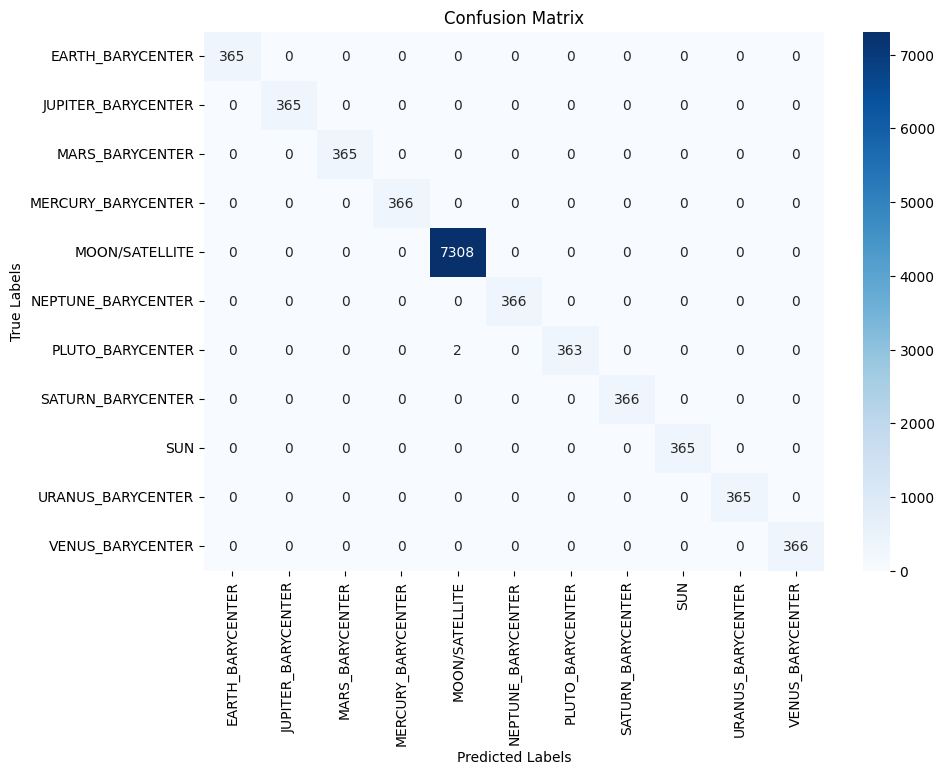

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class names for heatmap labels
# Ensure df_filtered is available from the previous cell
class_names = sorted(df_filtered['simplified_name'].unique())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

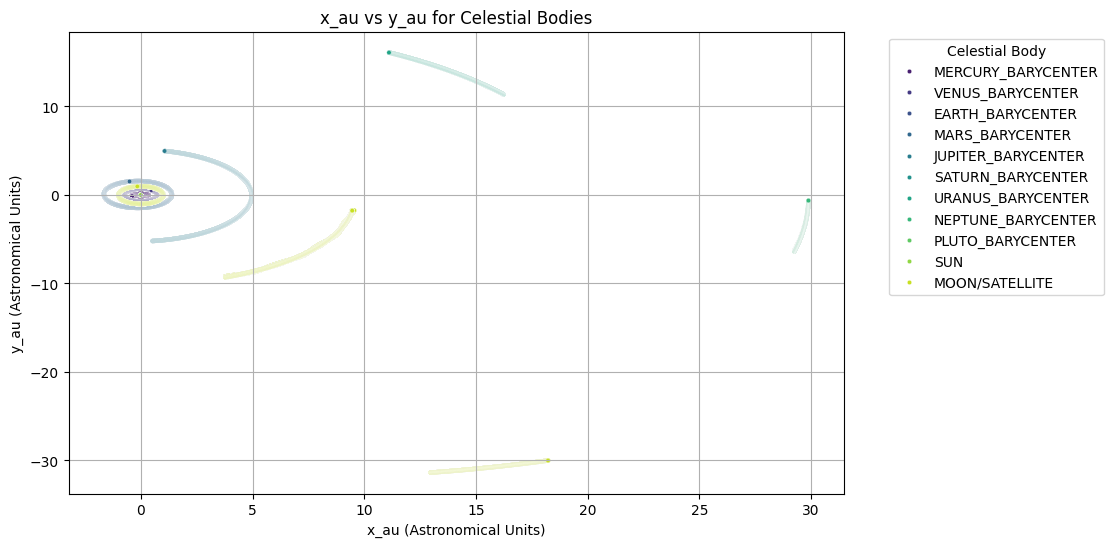

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='x_au', y='y_au', hue='simplified_name', palette='viridis', s=10)
plt.title('x_au vs y_au for Celestial Bodies')
plt.xlabel('x_au (Astronomical Units)')
plt.ylabel('y_au (Astronomical Units)')
plt.legend(title='Celestial Body', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Ensure 'date' column is datetime type and sort data
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Features to use for LSTM model
lstm_features = ['x_au', 'y_au', 'z_au', 'vx_au_per_day', 'vy_au_per_day', 'vz_au_per_day']
n_features = len(lstm_features)

# Parameters for LSTM
n_steps_in = 30  # Number of past time steps to use as input
n_steps_out = 1 # Number of future time steps to predict (predicting 1 day at a time)
n_future_days = 1 * 365 # Predict for 10 years (approx.)

# Store all future predictions
all_future_predictions_list = []

unique_bodies = df_filtered['simplified_name'].unique()

for body_name in unique_bodies:
    print(f"Processing {body_name}...")
    body_df = df_filtered[df_filtered['simplified_name'] == body_name].copy()
    body_df = body_df.sort_values(by='date').reset_index(drop=True)

    if len(body_df) < n_steps_in + n_steps_out:
        print(f"Not enough data for {body_name} (found {len(body_df)} points, need {n_steps_in + n_steps_out}). Skipping.")
        continue

    # Select and scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(body_df[lstm_features])

    # Create sequences for training
    X_seq, y_seq = [], []
    for i in range(len(scaled_data) - n_steps_in - n_steps_out + 1):
        X_seq.append(scaled_data[i:(i + n_steps_in), :])
        y_seq.append(scaled_data[i + n_steps_in : i + n_steps_in + n_steps_out, :]) # Target is the next step(s)
    
    if not X_seq:
        print(f"Not enough data after sequencing for {body_name}. Skipping.")
        continue
        
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    # Reshape y_seq for a Dense output layer: (samples, n_features) if n_steps_out=1
    # or (samples, n_steps_out * n_features) if predicting multiple steps flat
    # or (samples, n_steps_out, n_features) if using TimeDistributed Dense or another LSTM for output
    # For simplicity, predicting 1 step (n_steps_out=1), so y_seq should be (samples, n_features)
    y_seq = y_seq.reshape(y_seq.shape[0], n_features)


    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(Dense(n_features)) # Output layer predicts all features for the next single step
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=2)
    print(f"Training LSTM for {body_name}...")
    model.fit(X_seq, y_seq, epochs=50, batch_size=32, verbose=2, callbacks=[early_stopping])

    # Iterative prediction for the future
    # Get the last known sequence from historical data (scaled)
    last_sequence_scaled = scaled_data[-n_steps_in:] 
    current_sequence_for_prediction = last_sequence_scaled.reshape((1, n_steps_in, n_features))
    
    future_predictions_scaled_list = []

    print(f"Predicting future for {body_name}...")
    for _ in range(n_future_days):
        next_pred_scaled = model.predict(current_sequence_for_prediction, verbose=2) # Shape (1, n_features)
        future_predictions_scaled_list.append(next_pred_scaled[0])
        
        # Update current_sequence_for_prediction: remove oldest step, append newest prediction
        # Reshape next_pred_scaled to (1, 1, n_features) to append
        new_step_to_append = next_pred_scaled.reshape((1, 1, n_features))
        current_sequence_for_prediction = np.concatenate(
            (current_sequence_for_prediction[:, 1:, :], new_step_to_append), axis=1
        )

    # Inverse transform the predictions
    future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions_scaled_list))
    
    # Create dates for the future predictions
    last_date_in_history = body_df['date'].iloc[-1]
    future_dates = pd.date_range(start=last_date_in_history + pd.Timedelta(days=1), periods=n_future_days, freq='D')
    
    # Create DataFrame for this body's future predictions
    body_future_df = pd.DataFrame(future_predictions_unscaled, columns=lstm_features)
    body_future_df['date'] = future_dates
    body_future_df['simplified_name'] = body_name
    
    # Carry over 'name' and 'naif_id' if they exist and are consistent
    if 'name' in body_df.columns:
        body_future_df['name'] = body_df['name'].iloc[-1] 
    if 'naif_id' in body_df.columns:
        body_future_df['naif_id'] = body_df['naif_id'].iloc[-1]

    all_future_predictions_list.append(body_future_df)
    print(f"Finished processing {body_name}.")

# Combine all future predictions into a single DataFrame
if all_future_predictions_list:
    extended_df_predictions = pd.concat(all_future_predictions_list, ignore_index=True)
    
    # Attempt to reorder columns to match original df_filtered
    original_cols_order = df_filtered.columns.tolist()
    # Filter to columns present in extended_df_predictions, maintaining original order
    current_cols_in_order = [col for col in original_cols_order if col in extended_df_predictions.columns]
    # Add any new columns not in original, if any (though not expected here)
    # new_cols = [col for col in extended_df_predictions.columns if col not in current_cols_in_order]
    # final_cols_order = current_cols_in_order + new_cols
    extended_df_predictions = extended_df_predictions[current_cols_in_order]

    print("\n--- Sample of Future Predictions ---")
    print(extended_df_predictions.head())
    print(f"\nTotal predicted data points: {len(extended_df_predictions)}")

    # To combine with the original df_filtered:
    # df_combined = pd.concat([df_filtered, extended_df_predictions], ignore_index=True)
    # print("\n--- Combined DataFrame (Original + Predictions) ---")
    # print(df_combined.info())
    # print(df_combined.tail()) # Show some of the newly appended data
else:
    print("No predictions were generated. This might be due to insufficient data for all bodies.")

# The variable 'extended_df_predictions' now holds the 10-year forecast.
# You can concatenate it with 'df_filtered' if desired.

Processing MERCURY_BARYCENTER...
Training LSTM for MERCURY_BARYCENTER...
Epoch 1/50


c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 14ms/step - loss: 0.1314
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 0.0015
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 8.9952e-05
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 3.8734e-05
Epoch 5/50
57/57 - 0s - 4ms/step - loss: 2.3624e-05
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 1.6891e-05
Epoch 7/50
57/57 - 0s - 4ms/step - loss: 1.3820e-05
Epoch 8/50
57/57 - 0s - 4ms/step - loss: 1.1987e-05
Epoch 9/50
57/57 - 0s - 5ms/step - loss: 1.0096e-05
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 8.8135e-06
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 7.9638e-06
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 7.0838e-06
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 6.3845e-06
Epoch 14/50
57/57 - 0s - 4ms/step - loss: 6.0565e-06
Epoch 15/50
57/57 - 0s - 4ms/step - loss: 5.1809e-06
Epoch 16/50
57/57 - 0s - 4ms/step - loss: 5.0109e-06
Epoch 17/50
57/57 - 0s - 5ms/step - loss: 4.2253e-06
Epoch 18/50
57/57 - 0s - 4ms/step - loss: 4.0377e-06
Epoch 19/50
57/57 - 0s - 4ms/step - loss: 3.9094e-06
Epoch 20/50
57/57 - 

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 13ms/step - loss: 0.0932
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 8.1018e-04
Epoch 3/50
57/57 - 0s - 5ms/step - loss: 4.9575e-05
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 2.2273e-05
Epoch 5/50
57/57 - 0s - 5ms/step - loss: 1.2917e-05
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 8.4901e-06
Epoch 7/50
57/57 - 0s - 5ms/step - loss: 6.4756e-06
Epoch 8/50
57/57 - 0s - 4ms/step - loss: 5.0300e-06
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 4.3835e-06
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 3.6395e-06
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 3.3579e-06
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 3.0546e-06
Epoch 13/50
57/57 - 0s - 5ms/step - loss: 2.6436e-06
Epoch 14/50
57/57 - 0s - 5ms/step - loss: 2.4012e-06
Epoch 15/50
57/57 - 0s - 4ms/step - loss: 2.3433e-06
Epoch 16/50
57/57 - 0s - 5ms/step - loss: 2.0579e-06
Epoch 17/50
57/57 - 0s - 4ms/step - loss: 2.1113e-06
Epoch 18/50
57/57 - 0s - 4ms/step - loss: 1.7557e-06
Epoch 19/50
57/57 - 0s - 4ms/step - loss: 1.6933e-06
Epoch 20/50
57/5

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 14ms/step - loss: 0.1460
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 0.0016
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 2.3086e-04
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 1.9481e-04
Epoch 5/50
57/57 - 0s - 5ms/step - loss: 1.6514e-04
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 1.5533e-04
Epoch 7/50
57/57 - 0s - 4ms/step - loss: 1.4468e-04
Epoch 8/50
57/57 - 0s - 5ms/step - loss: 1.3701e-04
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 1.3130e-04
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 1.3181e-04
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 1.2425e-04
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 1.1758e-04
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 1.1108e-04
Epoch 14/50
57/57 - 0s - 4ms/step - loss: 1.0659e-04
Epoch 15/50
57/57 - 0s - 4ms/step - loss: 1.0135e-04
Epoch 16/50
57/57 - 0s - 4ms/step - loss: 1.0233e-04
Epoch 17/50
57/57 - 0s - 4ms/step - loss: 9.7143e-05
Epoch 18/50
57/57 - 0s - 4ms/step - loss: 8.9617e-05
Epoch 19/50
57/57 - 0s - 5ms/step - loss: 8.6683e-05
Epoch 20/50
57/57 - 

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 13ms/step - loss: 0.0710
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 7.3456e-04
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 5.3047e-05
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 2.8090e-05
Epoch 5/50
57/57 - 0s - 4ms/step - loss: 1.8724e-05
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 1.4271e-05
Epoch 7/50
57/57 - 0s - 4ms/step - loss: 1.0230e-05
Epoch 8/50
57/57 - 0s - 4ms/step - loss: 8.5850e-06
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 7.1052e-06
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 6.2726e-06
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 7.7094e-06
Epoch 12/50
57/57 - 0s - 5ms/step - loss: 5.6128e-06
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 4.6389e-06
Epoch 14/50
57/57 - 0s - 4ms/step - loss: 4.7819e-06
Epoch 15/50
57/57 - 0s - 5ms/step - loss: 4.4034e-06
Epoch 16/50
57/57 - 0s - 4ms/step - loss: 4.1704e-06
Epoch 17/50
57/57 - 0s - 4ms/step - loss: 5.8628e-06
Epoch 18/50
57/57 - 0s - 4ms/step - loss: 4.5839e-06
Epoch 19/50
57/57 - 0s - 4ms/step - loss: 4.4398e-06
Epoch 20/50
57/5

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 13ms/step - loss: 0.1110
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 0.0024
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 8.9738e-05
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 4.1415e-05
Epoch 5/50
57/57 - 0s - 4ms/step - loss: 2.5966e-05
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 1.6481e-05
Epoch 7/50
57/57 - 0s - 4ms/step - loss: 1.0135e-05
Epoch 8/50
57/57 - 0s - 4ms/step - loss: 8.5591e-06
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 6.0321e-06
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 6.0408e-06
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 4.3754e-06
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 3.4470e-06
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 3.1901e-06
Epoch 14/50
57/57 - 0s - 5ms/step - loss: 3.6860e-06
Epoch 15/50
57/57 - 0s - 5ms/step - loss: 2.5794e-06
Epoch 16/50
57/57 - 0s - 5ms/step - loss: 2.3617e-06
Epoch 17/50
57/57 - 0s - 5ms/step - loss: 2.4123e-06
Epoch 18/50
57/57 - 0s - 4ms/step - loss: 1.9778e-06
Epoch 19/50
57/57 - 0s - 4ms/step - loss: 2.9282e-06
Epoch 20/50
57/57 - 

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 14ms/step - loss: 0.0963
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 8.3140e-04
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 9.5444e-05
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 4.2421e-05
Epoch 5/50
57/57 - 0s - 4ms/step - loss: 2.3638e-05
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 1.4764e-05
Epoch 7/50
57/57 - 0s - 4ms/step - loss: 1.0197e-05
Epoch 8/50
57/57 - 0s - 4ms/step - loss: 7.2392e-06
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 5.2812e-06
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 3.7890e-06
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 2.7254e-06
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 2.3253e-06
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 2.1371e-06
Epoch 14/50
57/57 - 0s - 5ms/step - loss: 2.0281e-06
Epoch 15/50
57/57 - 0s - 5ms/step - loss: 1.7652e-06
Epoch 16/50
57/57 - 0s - 5ms/step - loss: 1.6264e-06
Epoch 17/50
57/57 - 0s - 5ms/step - loss: 1.5727e-06
Epoch 18/50
57/57 - 0s - 6ms/step - loss: 1.3711e-06
Epoch 19/50
57/57 - 0s - 5ms/step - loss: 1.2791e-06
Epoch 20/50
57/5

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 14ms/step - loss: 0.0992
Epoch 2/50
57/57 - 0s - 6ms/step - loss: 4.4778e-04
Epoch 3/50
57/57 - 0s - 5ms/step - loss: 4.1348e-05
Epoch 4/50
57/57 - 0s - 5ms/step - loss: 1.9671e-05
Epoch 5/50
57/57 - 0s - 5ms/step - loss: 1.1791e-05
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 7.9303e-06
Epoch 7/50
57/57 - 0s - 4ms/step - loss: 5.3528e-06
Epoch 8/50
57/57 - 0s - 4ms/step - loss: 3.9587e-06
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 3.0805e-06
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 2.5071e-06
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 2.1541e-06
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 1.8220e-06
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 1.5688e-06
Epoch 14/50
57/57 - 0s - 4ms/step - loss: 1.3213e-06
Epoch 15/50
57/57 - 0s - 5ms/step - loss: 1.1296e-06
Epoch 16/50
57/57 - 0s - 4ms/step - loss: 9.7515e-07
Epoch 17/50
57/57 - 0s - 4ms/step - loss: 8.7654e-07
Epoch 18/50
57/57 - 0s - 4ms/step - loss: 8.4088e-07
Epoch 19/50
57/57 - 0s - 4ms/step - loss: 7.2356e-07
Epoch 20/50
57/5

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 13ms/step - loss: 0.1005
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 8.3173e-04
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 6.1030e-05
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 2.6133e-05
Epoch 5/50
57/57 - 0s - 4ms/step - loss: 1.6715e-05
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 1.0217e-05
Epoch 7/50
57/57 - 0s - 4ms/step - loss: 9.3425e-06
Epoch 8/50
57/57 - 0s - 4ms/step - loss: 6.3231e-06
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 4.9758e-06
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 4.2306e-06
Epoch 11/50
57/57 - 0s - 4ms/step - loss: 3.4138e-06
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 3.0123e-06
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 2.7940e-06
Epoch 14/50
57/57 - 0s - 4ms/step - loss: 2.6490e-06
Epoch 15/50
57/57 - 0s - 4ms/step - loss: 5.0730e-06
Epoch 16/50
57/57 - 0s - 4ms/step - loss: 2.5279e-06
Epoch 17/50
57/57 - 0s - 4ms/step - loss: 1.9190e-06
Epoch 18/50
57/57 - 0s - 4ms/step - loss: 1.8237e-06
Epoch 19/50
57/57 - 0s - 4ms/step - loss: 1.9356e-06
Epoch 20/50
57/5

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 15ms/step - loss: 0.0504
Epoch 2/50
57/57 - 0s - 5ms/step - loss: 3.6439e-04
Epoch 3/50
57/57 - 0s - 5ms/step - loss: 3.0366e-05
Epoch 4/50
57/57 - 0s - 5ms/step - loss: 1.2290e-05
Epoch 5/50
57/57 - 0s - 5ms/step - loss: 8.7552e-06
Epoch 6/50
57/57 - 0s - 5ms/step - loss: 7.0860e-06
Epoch 7/50
57/57 - 0s - 5ms/step - loss: 6.0333e-06
Epoch 8/50
57/57 - 0s - 5ms/step - loss: 5.4169e-06
Epoch 9/50
57/57 - 0s - 5ms/step - loss: 4.5677e-06
Epoch 10/50
57/57 - 0s - 6ms/step - loss: 4.1979e-06
Epoch 11/50
57/57 - 0s - 5ms/step - loss: 4.0780e-06
Epoch 12/50
57/57 - 0s - 5ms/step - loss: 3.4046e-06
Epoch 13/50
57/57 - 0s - 6ms/step - loss: 3.0685e-06
Epoch 14/50
57/57 - 0s - 5ms/step - loss: 2.9262e-06
Epoch 15/50
57/57 - 0s - 5ms/step - loss: 2.7729e-06
Epoch 16/50
57/57 - 0s - 4ms/step - loss: 2.5826e-06
Epoch 17/50
57/57 - 0s - 5ms/step - loss: 2.2280e-06
Epoch 18/50
57/57 - 0s - 6ms/step - loss: 2.2060e-06
Epoch 19/50
57/57 - 0s - 6ms/step - loss: 1.8017e-06
Epoch 20/50
57/5

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 1s - 14ms/step - loss: 0.0000e+00
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 0.0000e+00
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 0.0000e+00
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 0.0000e+00
Epoch 5/50
57/57 - 0s - 5ms/step - loss: 0.0000e+00
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 0.0000e+00
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Predicting future for SUN...
1/1 - 0s - 70ms/step
1/1 - 0s - 22ms/step
1/1 - 0s - 22ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 24ms/step
1/1 - 0s - 23ms/step
1/1 - 0s - 23ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 19ms/step
1/1 - 0s - 19ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 21ms/step
1/1 - 0s - 18ms/ste

c:\ARF\my-repos\RBL-AnalisisData-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1141/1141 - 5s - 4ms/step - loss: 0.0521
Epoch 2/50
1141/1141 - 5s - 4ms/step - loss: 0.0473
Epoch 3/50
1141/1141 - 5s - 4ms/step - loss: 0.0470
Epoch 4/50
1141/1141 - 6s - 5ms/step - loss: 0.0468
Epoch 5/50
1141/1141 - 6s - 5ms/step - loss: 0.0467
Epoch 6/50
1141/1141 - 4s - 4ms/step - loss: 0.0466
Epoch 7/50
1141/1141 - 4s - 4ms/step - loss: 0.0465
Epoch 8/50
1141/1141 - 4s - 4ms/step - loss: 0.0465
Epoch 9/50
1141/1141 - 4s - 4ms/step - loss: 0.0465
Epoch 10/50
1141/1141 - 4s - 4ms/step - loss: 0.0465
Epoch 11/50
1141/1141 - 4s - 4ms/step - loss: 0.0464
Epoch 12/50
1141/1141 - 5s - 4ms/step - loss: 0.0464
Epoch 13/50
1141/1141 - 5s - 4ms/step - loss: 0.0463
Epoch 14/50
1141/1141 - 4s - 4ms/step - loss: 0.0463
Epoch 15/50
1141/1141 - 4s - 4ms/step - loss: 0.0463
Epoch 16/50
1141/1141 - 4s - 4ms/step - loss: 0.0463
Epoch 17/50
1141/1141 - 4s - 4ms/step - loss: 0.0463
Epoch 18/50
1141/1141 - 5s - 4ms/step - loss: 0.0462
Epoch 19/50
1141/1141 - 4s - 4ms/step - loss: 0.0462
Epoch 20/50
1

In [17]:
extended_df_predictions

,date,name,naif_id,x_au,y_au,z_au,vx_au_per_day,vy_au_per_day,vz_au_per_day,simplified_name
0,2025-01-01,1 MERCURY BARYCENTER,1,-0.387744,-0.161119,0.022309,0.005020,-0.024842,-0.002491,MERCURY_BARYCENTER
1,2025-01-02,1 MERCURY BARYCENTER,1,-0.382150,-0.185730,0.019823,0.006490,-0.024112,-0.002568,MERCURY_BARYCENTER
2,2025-01-03,1 MERCURY BARYCENTER,1,-0.374763,-0.209595,0.017264,0.007933,-0.023285,-0.002632,MERCURY_BARYCENTER
3,2025-01-04,1 MERCURY BARYCENTER,1,-0.365855,-0.232596,0.014638,0.009337,-0.022391,-0.002685,MERCURY_BARYCENTER
4,2025-01-05,1 MERCURY BARYCENTER,1,-0.355953,-0.254704,0.011968,0.010680,-0.021490,-0.002732,MERCURY_BARYCENTER
...,...,...,...,...,...,...,...,...,...,...
4010,2025-12-27,905 STYX,905,10.395307,-15.857561,-0.862284,0.000984,0.000722,-0.000624,MOON/SATELLITE
4011,2025-12-28,905 STYX,905,10.340078,-15.784121,-0.858896,0.000977,0.000723,-0.000624,MOON/SATELLITE
4012,2025-12-29,905 STYX,905,10.286397,-15.690107,-0.854599,0.000977,0.000733,-0.000622,MOON/SATELLITE
4013,2025-12-30,905 STYX,905,10.241573,-15.598939,-0.850328,0.000982,0.000746,-0.000619,MOON/SATELLITE


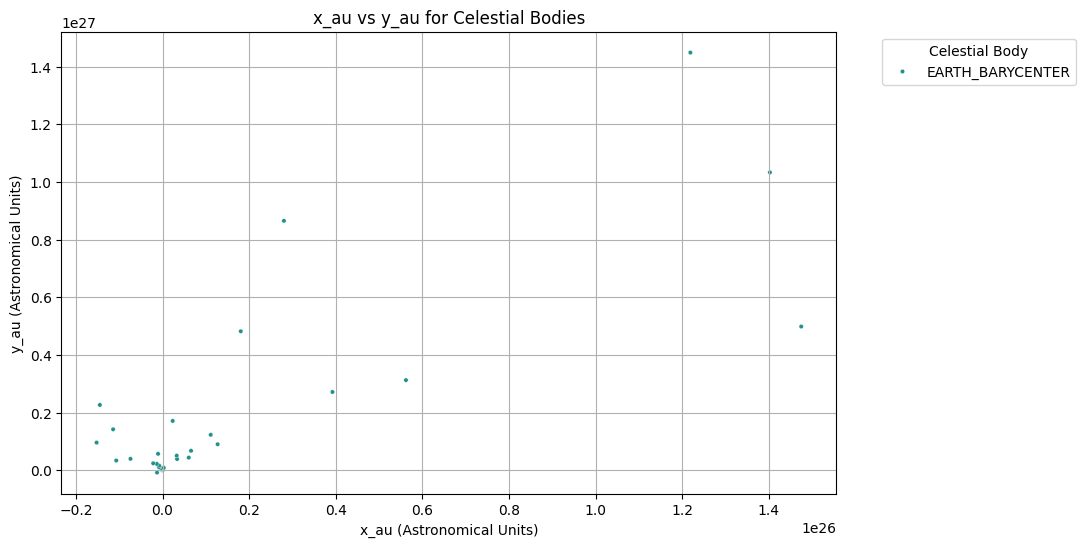

In [23]:
plot_df = extended_df_predictions[extended_df_predictions['simplified_name'] == 'EARTH_BARYCENTER']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='x_au', y='y_au', hue='simplified_name', palette='viridis', s=10)
plt.title('x_au vs y_au for Celestial Bodies')
plt.xlabel('x_au (Astronomical Units)')
plt.ylabel('y_au (Astronomical Units)')
plt.legend(title='Celestial Body', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

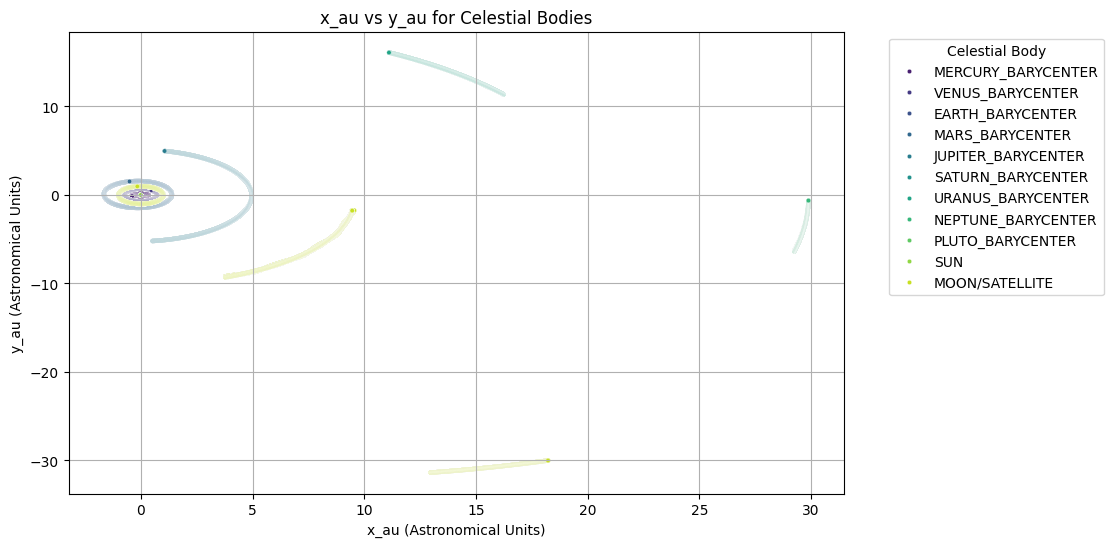

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='x_au', y='y_au', hue='simplified_name', palette='viridis', s=10)
plt.title('x_au vs y_au for Celestial Bodies')
plt.xlabel('x_au (Astronomical Units)')
plt.ylabel('y_au (Astronomical Units)')
plt.legend(title='Celestial Body', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()